# Model training with RFC
Derived from exploratory_model_training.ipynb but removing pixel rows 41-128 for faster training

In [1]:
# Imports
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
# Import np arrays
X = np.load('../data/processed/pln_X_small_features_raw_128x128.npy')
y = np.load('../data/processed/pln_y_small_labels.npy')

In [3]:
# Data pipeline
# Remove row 41-128 based on feature importance
X_reshape = X.reshape(-1, 128, 128)
X_top40 = X_reshape[:, :40, :]
X_top40_flat = X_top40.reshape(X_top40.shape[0], -1)


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_top40_flat, y, test_size=0.20, 
    random_state=42,
    stratify=y
)

In [5]:
# Scaling
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Setting Param grid for RFC
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


In [7]:
# Initializing model
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc, param_grid, n_jobs=-1)


In [8]:
# Fitting GridSearchCV
grid.fit(X_trained_scaled, y_train)


,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [9]:
results = pl.DataFrame(grid.cv_results_)
top3 = results.sort("mean_test_score", descending=True).head(3)
for row in top3.iter_rows(named=True):
    print(f"Score: {row['mean_test_score']:.4f}, Params: {row['params']}")
best_rfc = grid.best_estimator_

Score: 0.9425, Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.9400, Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Score: 0.9400, Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}


              precision    recall  f1-score   support

           0       0.99      0.95      0.97        86
           1       0.76      0.93      0.84        14

    accuracy                           0.95       100
   macro avg       0.88      0.94      0.90       100
weighted avg       0.96      0.95      0.95       100



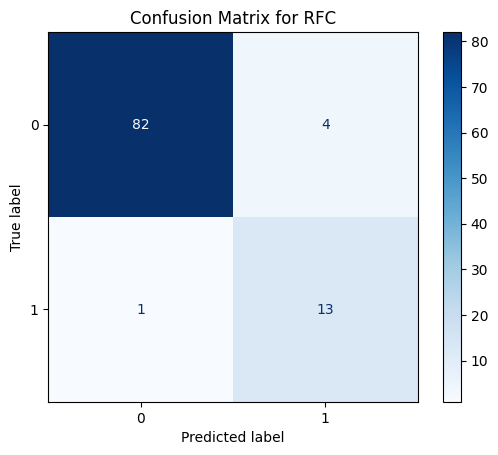

In [ ]:
# Score and Confusion Matrix with lower threshold
y_proba = best_rfc.predict_proba(X_test_scaled)[:, 1]
threshold = 0.2 # <- lower threshold for more TP
y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for RFC")
plt.show()
